Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.549061
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.714095
Minibatch accuracy: 50.0%
Validation accuracy: 45.6%
Minibatch loss at step 100: 1.125689
Minibatch accuracy: 50.0%
Validation accuracy: 75.3%
Minibatch loss at step 150: 1.023909
Minibatch accuracy: 62.5%
Validation accuracy: 74.4%
Minibatch loss at step 200: 0.840835
Minibatch accuracy: 75.0%
Validation accuracy: 77.5%
Minibatch loss at step 250: 0.910794
Minibatch accuracy: 75.0%
Validation accuracy: 78.8%
Minibatch loss at step 300: 1.398120
Minibatch accuracy: 62.5%
Validation accuracy: 79.2%
Minibatch loss at step 350: 0.672391
Minibatch accuracy: 75.0%
Validation accuracy: 78.2%
Minibatch loss at step 400: 0.648095
Minibatch accuracy: 81.2%
Validation accuracy: 79.4%
Minibatch loss at step 450: 0.631746
Minibatch accuracy: 81.2%
Validation accuracy: 80.5%
Minibatch loss at step 500: 0.740096
Minibatch accuracy: 75.0%
Validation accuracy: 80.6%
Mi

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [7]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # functions for convolution layers to clean up code 
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    
    # pooling stride = 2 and kernel = 2 
    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    #### Variables.
    # The first two dimensions are the patch size, 
    # the next is the number of input channels, 
    # and the last is the number of output channels. 
    # We will also have a bias vector with a component for each output channel.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        conv_1 = conv2d(data, layer1_weights) # create the convolution layer 1
        hidden_1 = tf.nn.relu(conv_1 + layer1_biases) # create relu
        hidden_pool_1 = max_pool_2x2(hidden_1) # pool the layer 
        
        conv_2 = conv2d(hidden_pool_1, layer2_weights)
        hidden_2 = tf.nn.relu(conv_2 + layer2_biases)
        hidden_pool_2 = max_pool_2x2(hidden_2)
        
        shape = hidden_pool_2.get_shape().as_list()
        reshape = tf.reshape(hidden_pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [8]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.846282
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 2.121958
Minibatch accuracy: 18.8%
Validation accuracy: 27.4%
Minibatch loss at step 100: 1.478858
Minibatch accuracy: 37.5%
Validation accuracy: 59.4%
Minibatch loss at step 150: 1.133380
Minibatch accuracy: 75.0%
Validation accuracy: 73.1%
Minibatch loss at step 200: 0.662815
Minibatch accuracy: 87.5%
Validation accuracy: 75.6%
Minibatch loss at step 250: 0.890906
Minibatch accuracy: 68.8%
Validation accuracy: 79.6%
Minibatch loss at step 300: 1.496962
Minibatch accuracy: 68.8%
Validation accuracy: 79.9%
Minibatch loss at step 350: 0.612056
Minibatch accuracy: 81.2%
Validation accuracy: 80.8%
Minibatch loss at step 400: 0.914725
Minibatch accuracy: 81.2%
Validation accuracy: 81.8%
Minibatch loss at step 450: 0.800929
Minibatch accuracy: 68.8%
Validation accuracy: 81.8%
Minibatch loss at step 500: 0.962858
Minibatch accuracy: 75.0%
Validation accuracy: 82.0%
Mi

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [10]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
starter_learning_rate = 0.05
decay_steps = 100
decay_base = 0.95
staircase = True 

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # functions for convolution layers to clean up code 
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    
    # pooling stride = 2 and kernel = 2 
    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    #### Variables.
    # The first two dimensions are the patch size, 
    # the next is the number of input channels, 
    # and the last is the number of output channels. 
    # We will also have a bias vector with a component for each output channel.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  

    # Model. #LeNet5 -> Convolution -> Pool -> Convolution -> Pool -> Hidden -> Full Connection 
    def model(data):
        conv_1 = conv2d(data, layer1_weights) # create the convolution layer 1
        relu_1 = tf.nn.relu(conv_1 + layer1_biases) # relu -> rectified linear unit (activation function)
        pool_1 = max_pool_2x2(relu_1) # pool the layer 
        
        conv_2 = conv2d(pool_1, layer2_weights) # create the convolution layer 2
        relu_2 = tf.nn.relu(conv_2 + layer2_biases) # relu -> rectified linear unit (activation function)
        pool_2 = max_pool_2x2(relu_2) # pool the layer
        
        shape = pool_2.get_shape().as_list() # get the shape for reshaping and connection 
        reshape = tf.reshape(pool_2, [shape[0], shape[1] * shape[2] * shape[3]]) # reshape 
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases) # connect hidden layer 
        
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        starter_learning_rate, global_step, decay_steps, decay_base, staircase=staircase)
    optimizer = tf.train.GradientDescentOptimizer(starter_learning_rate).minimize(loss, global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [23]:
num_steps = 951 # stop early 
step_list = []
minibatch_loss = []
minibatch_accuracy = []
validation_accuracy = []

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 50 == 0):
            # for plotting 
            step_list.append(step) # add the step to the list for plotting
            minibatch_loss.append(l)
            minibatch_accuracy.append(accuracy(predictions, batch_labels))
            validation_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
            
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.370903
Minibatch accuracy: 6.2%
Validation accuracy: 10.9%
Minibatch loss at step 50: 1.678922
Minibatch accuracy: 37.5%
Validation accuracy: 42.7%
Minibatch loss at step 100: 1.081429
Minibatch accuracy: 56.2%
Validation accuracy: 70.9%
Minibatch loss at step 150: 0.995007
Minibatch accuracy: 68.8%
Validation accuracy: 72.6%
Minibatch loss at step 200: 0.837783
Minibatch accuracy: 62.5%
Validation accuracy: 77.5%
Minibatch loss at step 250: 0.691995
Minibatch accuracy: 81.2%
Validation accuracy: 78.6%
Minibatch loss at step 300: 1.621343
Minibatch accuracy: 56.2%
Validation accuracy: 77.8%
Minibatch loss at step 350: 0.822572
Minibatch accuracy: 68.8%
Validation accuracy: 80.9%
Minibatch loss at step 400: 0.823837
Minibatch accuracy: 81.2%
Validation accuracy: 81.1%
Minibatch loss at step 450: 0.768118
Minibatch accuracy: 81.2%
Validation accuracy: 81.7%
Minibatch loss at step 500: 0.729166
Minibatch accuracy: 81.2%
Validation accuracy: 81.8%
Mi

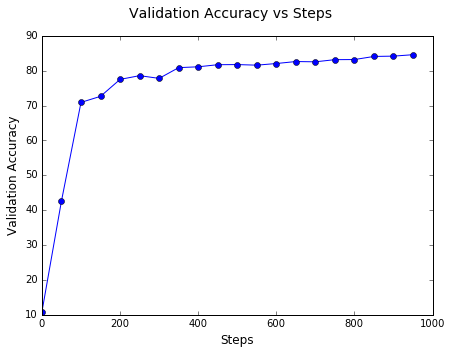

In [45]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.suptitle('Validation Accuracy vs Steps', fontsize=14)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.plot(step_list, validation_accuracy, '-o')

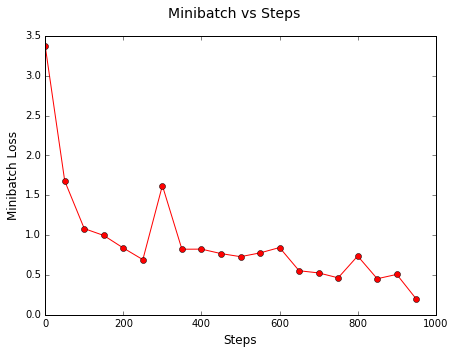

In [49]:
plt.figure(figsize=(7, 5))
plt.suptitle('Minibatch vs Steps', fontsize=14)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Minibatch Loss', fontsize=12)
plt.plot(step_list, minibatch_loss, '-o', color='r')

### Try previous model with dropout 

In [68]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
starter_learning_rate = 0.05
decay_steps = 100000
decay_base = 0.96
staircase = True 

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # functions for convolution layers to clean up code 
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    
    # pooling stride = 2 and kernel = 2 
    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    #### Variables.
    # The first two dimensions are the patch size, 
    # the next is the number of input channels, 
    # and the last is the number of output channels. 
    # We will also have a bias vector with a component for each output channel.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model. #LeNet5 -> Convolution -> Pool -> Convolution -> Pool -> Hidden -> Full Connection 
    def model(data):
        conv_1 = conv2d(data, layer1_weights) # create the convolution layer 1
        relu_1 = tf.nn.relu(conv_1 + layer1_biases) # relu -> rectified linear unit (activation function)
        pool_1 = max_pool_2x2(relu_1) # pool the layer 
        
        conv_2 = conv2d(pool_1, layer2_weights) # create the convolution layer 2
        relu_2 = tf.nn.relu(conv_2 + layer2_biases) # relu -> rectified linear unit (activation function)
        pool_2 = max_pool_2x2(relu_2) # pool the layer
        
        shape = pool_2.get_shape().as_list() # get the shape for reshaping and connection 
        reshape = tf.reshape(pool_2, [shape[0], shape[1] * shape[2] * shape[3]]) # reshape 
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases) # connect hidden layer 
        
        # added dropout to the hidden layer 
        hidden_dropout = tf.nn.dropout(hidden, 0.7)
        
        return tf.matmul(hidden_dropout, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        starter_learning_rate, global_step, decay_steps, decay_base, staircase=staircase)
    optimizer = tf.train.GradientDescentOptimizer(starter_learning_rate).minimize(loss, global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [69]:
num_steps = 901 # stop early 
step_list = []
minibatch_loss = []
minibatch_accuracy = []
validation_accuracy = []

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 50 == 0):
            # for plotting 
            step_list.append(step) # add the step to the list for plotting
            minibatch_loss.append(l)
            minibatch_accuracy.append(accuracy(predictions, batch_labels))
            validation_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
            
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.000603
Minibatch accuracy: 12.5%
Validation accuracy: 9.8%
Minibatch loss at step 50: 2.274433
Minibatch accuracy: 12.5%
Validation accuracy: 9.9%
Minibatch loss at step 100: 2.286866
Minibatch accuracy: 6.2%
Validation accuracy: 12.6%
Minibatch loss at step 150: 2.060619
Minibatch accuracy: 25.0%
Validation accuracy: 26.2%
Minibatch loss at step 200: 1.468961
Minibatch accuracy: 56.2%
Validation accuracy: 51.8%
Minibatch loss at step 250: 1.401427
Minibatch accuracy: 68.8%
Validation accuracy: 64.8%
Minibatch loss at step 300: 1.702942
Minibatch accuracy: 56.2%
Validation accuracy: 69.2%
Minibatch loss at step 350: 0.962274
Minibatch accuracy: 68.8%
Validation accuracy: 69.1%
Minibatch loss at step 400: 1.164730
Minibatch accuracy: 56.2%
Validation accuracy: 74.6%
Minibatch loss at step 450: 0.724648
Minibatch accuracy: 68.8%
Validation accuracy: 75.0%
Minibatch loss at step 500: 0.998830
Minibatch accuracy: 81.2%
Validation accuracy: 76.4%
Mini

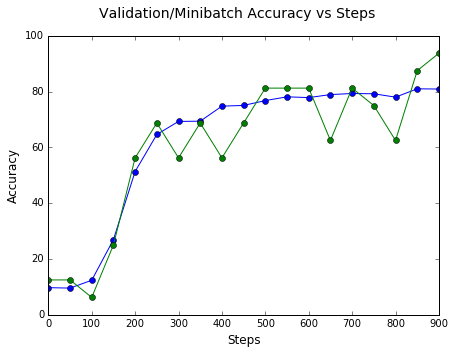

In [71]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.suptitle('Validation/Minibatch Accuracy vs Steps', fontsize=14)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(step_list, validation_accuracy, '-o')
plt.plot(step_list, minibatch_accuracy, '-o')

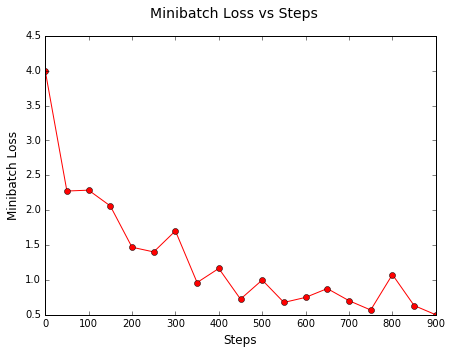

In [73]:
plt.figure(figsize=(7, 5))
plt.suptitle('Minibatch Loss vs Steps', fontsize=14)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Minibatch Loss', fontsize=12)
plt.plot(step_list, minibatch_loss, '-o', color='r')